In [1]:
# pip install pandas --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('동박데이터-등차결측치.csv', thousands = ',')  # 천 단위 구분 반점(,) 없애기
df.head()

,날짜,시간,인가전류,조전압,공정액 Cl,공정액 TOC,A,B,C,D,활성탄,인장강도,연신율,광택도\n(GU),조도 M면,조도 S면\n(Ra),Curl
0,05월 13일,3,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,34.8,7.9,115.0,1.39,0.22,NaN
1,05월 13일,7,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,35.8,7.6,127.0,1.47,0.23,NaN
2,05월 13일,11,1.3,NaN,34.0,43.3,358.0,1090.0,1272.0,373.0,2.4,36.4,8.6,154.0,1.30,0.25,NaN
3,05월 13일,15,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,36.7,10.3,176.0,1.26,0.25,NaN
4,05월 13일,19,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,36.7,9.6,260.0,1.05,0.25,NaN


## 결측치 대체

In [3]:
# 공정액은 두 값들 사이를 등차로 결측치 보간
# 나머지는 평균
# for i in 공정액 :
# 데이터가 있으면, 인덱스를 받아서 (그전 인덱스 데이터 - 현 데이터) / (이번 인덱스 - 현 인덱스)

cl = []
toc = []
# null이 아닌 인덱스 append
for i in range(len(df['공정액 Cl'])):
    if df['공정액 Cl'].notnull()[i]:
        cl.append(i)
for i in range(len(df['공정액 TOC'])):
    if df['공정액 TOC'].notnull()[i]:
        toc.append(i)

# 공차를 구해서 빈 값들에 채워넣기
for j in range(len(cl)):
    if j < len(cl)-1:
        if cl[j+1] - cl[j] > 1: # 사이에 결측치 있으면
            diff = (df['공정액 Cl'][cl[j+1]] - df['공정액 Cl'][cl[j]]) / (cl[j+1] - cl[j])
            for k in range(cl[j],cl[j+1]):
                df['공정액 Cl'][k] = df['공정액 Cl'][cl[j]] + diff*(k-cl[j])
for j in range(len(toc)):
    if j < len(toc)-1:
        if toc[j+1] - toc[j] > 1: # 사이에 결측치 있으면
            diff = (df['공정액 TOC'][toc[j+1]] - df['공정액 TOC'][toc[j]]) / (toc[j+1] - toc[j])
            for k in range(toc[j],toc[j+1]):
                df['공정액 TOC'][k] = df['공정액 TOC'][toc[j]] + diff*(k-toc[j])          
        

C:\Users\cmson\AppData\Local\Temp\ipykernel_5888\3569616526.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['공정액 Cl'][k] = df['공정액 Cl'][cl[j]] + diff*(k-cl[j])
C:\Users\cmson\AppData\Local\Temp\ipykernel_5888\3569616526.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['공정액 TOC'][k] = df['공정액 TOC'][toc[j]] + diff*(k-toc[j])


In [4]:
# 평균으로 대체시 기존 값들과 편차 크므로, bfill, ffill 사용
df['공정액 Cl'] = df['공정액 Cl'].fillna(method='ffill') .fillna(method='bfill')
df['공정액 TOC'] = df['공정액 TOC'].fillna(method='ffill') .fillna(method='bfill')

In [5]:
# 변수별 평균으로 결측치 대체
df = df.fillna(df.mean())
df.head()

C:\Users\cmson\AppData\Local\Temp\ipykernel_5888\2272151833.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


,날짜,시간,인가전류,조전압,공정액 Cl,공정액 TOC,A,B,C,D,활성탄,인장강도,연신율,광택도\n(GU),조도 M면,조도 S면\n(Ra),Curl
0,05월 13일,3,1.3,4.351327,34.000000,43.300000,358.0,1090.0,1272.0,373.0,2.4,34.8,7.9,115.0,1.39,0.22,3.790875
1,05월 13일,7,1.3,4.351327,34.000000,43.300000,358.0,1090.0,1272.0,373.0,2.4,35.8,7.6,127.0,1.47,0.23,3.790875
2,05월 13일,11,1.3,4.351327,34.000000,43.300000,358.0,1090.0,1272.0,373.0,2.4,36.4,8.6,154.0,1.30,0.25,3.790875
3,05월 13일,15,1.3,4.351327,34.566667,47.966667,358.0,1090.0,1272.0,373.0,2.4,36.7,10.3,176.0,1.26,0.25,3.790875
4,05월 13일,19,1.3,4.351327,35.133333,52.633333,358.0,1090.0,1272.0,373.0,2.4,36.7,9.6,260.0,1.05,0.25,3.790875


## 상관관계 분석

C:\Users\cmson\AppData\Local\Temp\ipykernel_5888\718687137.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)
C:\Users\cmson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.draw()
C:\Users\cmson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.draw()
C:\Users

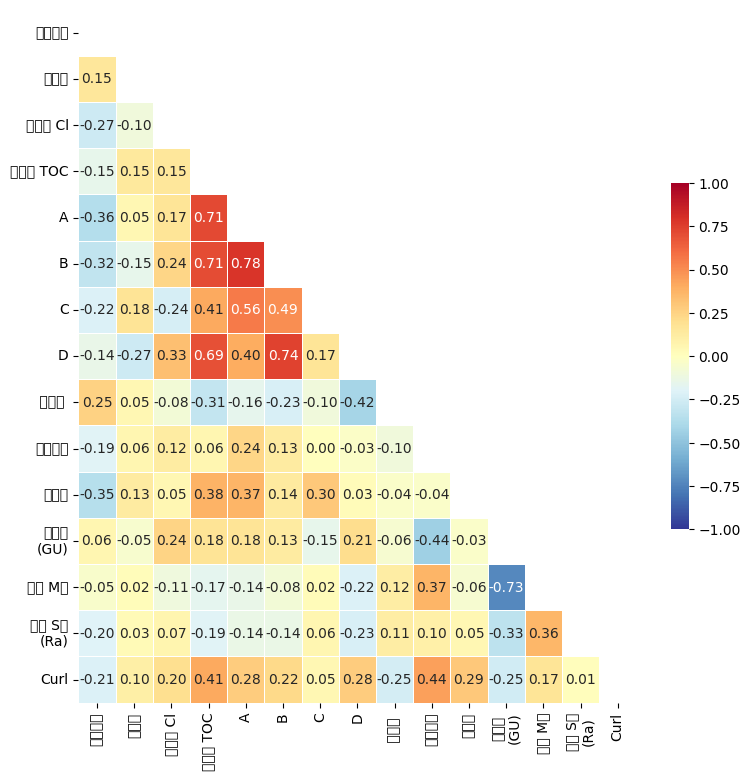

In [6]:
# heatmap
corr = df.drop(['시간','날짜'], axis=1).corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(9,9) )

# 삼각형 마스크(위 : True, 아래 : False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값 표시
            mask=mask,      # 표시하지 않을 마스크 부분 지정
            linewidths=.5,  # 경계면 구분
            cbar_kws={"shrink": .5},# 컬러바 크기 절반
            vmin = -1,vmax = 1,   # 컬러바 범위 -1 ~ 1
            fmt = '.2f'
           )  
plt.show()

## Train-Test split

In [7]:
x = df.drop(['날짜','시간','인장강도','연신율','광택도\n(GU)','조도 M면','조도 S면\n(Ra)','Curl'], axis=1).values
y1, y2, y3, y4, y5, y6 = df['인장강도'], df['연신율'], df['광택도\n(GU)'], df['조도 M면'], df['조도 S면\n(Ra)'], df['Curl']

In [8]:
x_train, x_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, y4_train, y4_test,y5_train, y5_test,y6_train, y6_test = train_test_split(x,y1,y2,y3,y4,y5,y6, train_size=0.7)

## PCA

In [9]:
scale = StandardScaler()
x_scaledtrain = scale.fit_transform(x_train)
x_scaledtest = scale.transform(x_test)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5) # 주성분 5개
x_pca_train = pca.fit_transform(x_scaledtrain)
x_pca_test = pca.transform(x_scaledtest)

print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)  # 89.14% 설명

[0.41003181 0.1673285  0.11548991 0.1055131  0.09991649]


0.8982798092159716

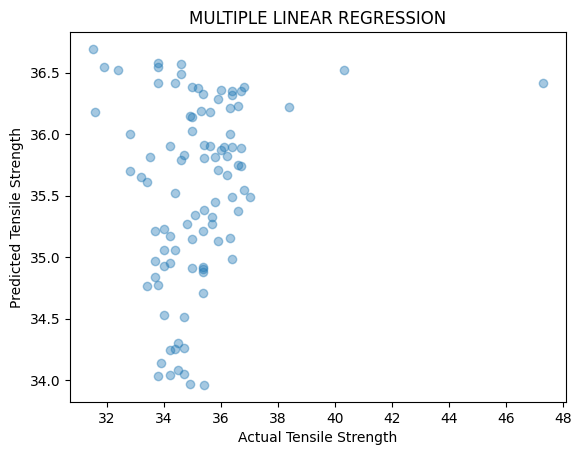

0.07983829311506774


In [11]:
mlr = LinearRegression()
mlr.fit(x_pca_train, y1_train)
y1_predict = mlr.predict(x_pca_test)

plt.scatter(y1_test, y1_predict, alpha=0.4)
plt.xlabel("Actual Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()
print(mlr.score(x_pca_train, y1_train))

In [12]:
# PCA R score
pca_score = []
mlr = LinearRegression()
mlr.fit(x_pca_train, y1_train)
pca_score.append(mlr.score(x_pca_train, y1_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y2_train)
pca_score.append(mlr.score(x_pca_train, y2_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y3_train)
pca_score.append(mlr.score(x_pca_train, y3_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y4_train)
pca_score.append(mlr.score(x_pca_train, y4_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y5_train)
pca_score.append(mlr.score(x_pca_train, y5_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y6_train)
pca_score.append(mlr.score(x_pca_train, y6_train))
pca_score

[0.07983829311506774,
 0.2243634668046922,
 0.07753779500427216,
 0.05344154082036756,
 0.16551532707159677,
 0.1981221676932211]

In [13]:
# PCA 안 한 R score
score = []
coef = []
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y1_train)
score.append(mlr.score(x_scaledtrain, y1_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y2_train)
score.append(mlr.score(x_scaledtrain, y2_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y3_train)
score.append(mlr.score(x_scaledtrain, y3_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y4_train)
score.append(mlr.score(x_scaledtrain, y4_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y5_train)
score.append(mlr.score(x_scaledtrain, y5_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y6_train)
score.append(mlr.score(x_scaledtrain, y6_train))
coef.append(mlr.coef_)
print(score)
print(coef)

[0.22213818766401372, 0.40748674804120355, 0.1111421118954321, 0.1151087075616406, 0.2618256679343356, 0.2604666021752241]
[array([-0.17195483,  0.33400814, -0.04080093, -0.58862774,  1.52385411,
        0.40573712, -1.03290069, -0.27821722, -0.26026022]), array([-1.13585387, -0.38186979,  0.06092246,  2.21616326,  0.47356824,
       -1.80412774,  0.74150672, -0.66862318,  0.33912685]), array([ 11.5435612 ,   3.11617899,   7.17770426,  -9.58642028,
        32.14206699, -21.21510554, -14.30111505,  27.24381142,
        -0.10899055]), array([-0.03434834, -0.02767175,  0.01853334,  0.08591178, -0.18187847,
        0.174578  ,  0.00915209, -0.21054623,  0.0039916 ]), array([-0.00667361, -0.0055386 ,  0.01102472,  0.00526562, -0.01944292,
        0.00915107,  0.00864775, -0.01664952,  0.00262438]), array([-1.01550903,  0.45485918,  0.39616296,  2.33899228,  0.5172155 ,
       -1.30312057, -0.62507215,  0.46744773, -0.26747166])]


In [16]:
for i in coef:
    print(i)

[-0.17195483  0.33400814 -0.04080093 -0.58862774  1.52385411  0.40573712
 -1.03290069 -0.27821722 -0.26026022]
[-1.13585387 -0.38186979  0.06092246  2.21616326  0.47356824 -1.80412774
  0.74150672 -0.66862318  0.33912685]
[ 11.5435612    3.11617899   7.17770426  -9.58642028  32.14206699
 -21.21510554 -14.30111505  27.24381142  -0.10899055]
[-0.03434834 -0.02767175  0.01853334  0.08591178 -0.18187847  0.174578
  0.00915209 -0.21054623  0.0039916 ]
[-0.00667361 -0.0055386   0.01102472  0.00526562 -0.01944292  0.00915107
  0.00864775 -0.01664952  0.00262438]
[-1.01550903  0.45485918  0.39616296  2.33899228  0.5172155  -1.30312057
 -0.62507215  0.46744773 -0.26747166]


In [ ]:
# train-test 분리
# x_train에 standardcale fit_transform, x_test에 transform
# scale한 x_train에 pca fit_transform, scale x_test에 transform
# LinearRegression


### 고민 및 앞으로의 방향성


1. 독립변수 9, 종속변수 6개 - 다변량 다중회귀?

        종속변수가 하나인 데이터만 다뤄보아서 일단은 PCA한 독립변수와 각각의 종속변수들 사이의 regression을 진행하려고 함 (총 6번의 개별적인 regression)
 
2. 독립변수에 대한 PCA를 진행했으나, 종속변수들은 PCA를 진행하지 않는 것인지? 

        즉, 상관관계 분석 시 종속변수 사이의 다중공선성은 고려하지 않아도 되는지?
        독립변수, 종속변수 분리하지 않고 모든 변수에 대해 PCA를 해야하는지?


3. 가설검정을 통해, 변수가 유의한지 파악해서 분석하기 (계량경제학 때 사용) 
